In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dataset_path = '/content/drive/MyDrive/Monument_Final_Data/train'
validation_dataset_path = '/content/drive/MyDrive/Monument_Final_Data/val'

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 10297 images belonging to 15 classes.
Found 746 images belonging to 15 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Amber Fort
1 : Brihadeeswarar Temple
2 : Fatehpur Sikri
3 : Golden Temple
4 : Hawa Mahal
5 : Humayun Tomb
6 : Lotus Bahai Temple
7 : Meenakshi Amman Temple
8 : Mysore Palace
9 : Purana Qila
10 : Qutab Minar, Delhi
11 : Safdarjung's Tomb
12 : Sanchi Stupa
13 : Taj Mahal
14 : Virupaksha Temple


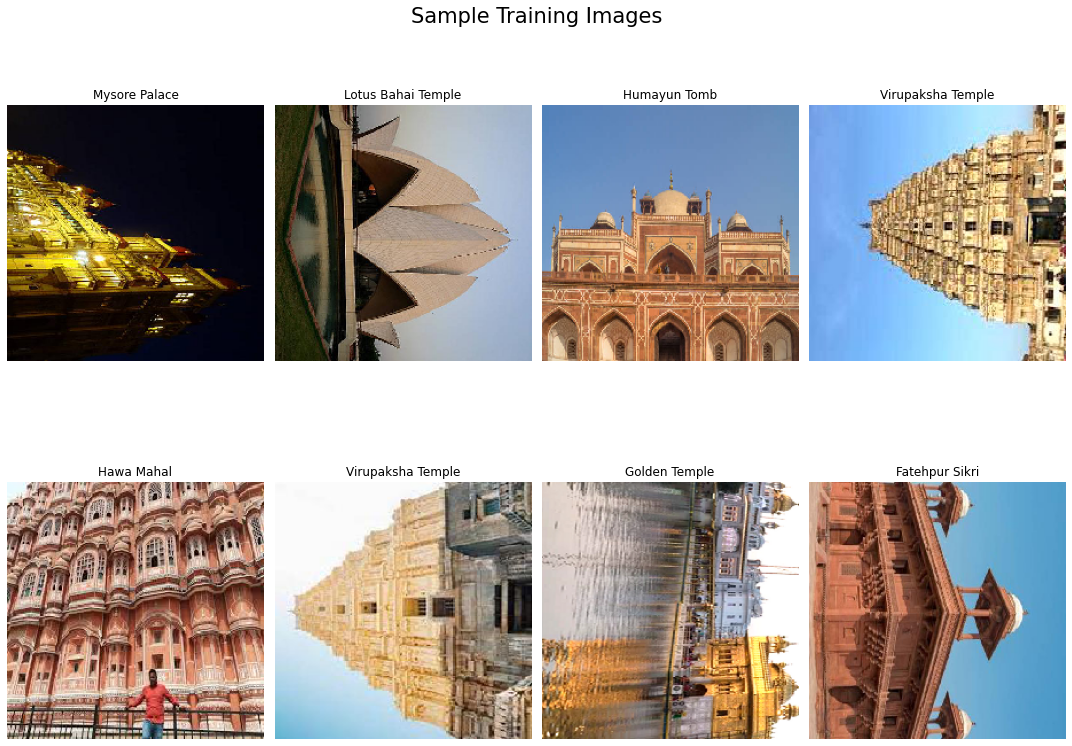

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [9]:
inception_base = applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
inception_base.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [15]:
inputs = Input(shape=(224, 224, 3))

x = inception_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation = 'softmax')(x)
inception_base = Model(inputs, outputs)


In [16]:
inception_base.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= ['accuracy'],
)

In [17]:
inception_base.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 15)                15375     
                                                           

In [18]:
epochs = 10
history_inception=inception_base.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


322/322 [==============================] - 3029s 9s/step - loss: 1.1403 - accuracy: 0.6490 - val_loss: 0.4302 - val_accuracy: 0.8606
Epoch 2/10
322/322 [==============================] - 136s 422ms/step - loss: 0.5782 - accuracy: 0.8107 - val_loss: 0.3180 - val_accuracy: 0.9035
Epoch 3/10
322/322 [==============================] - 134s 416ms/step - loss: 0.4722 - accuracy: 0.8445 - val_loss: 0.2836 - val_accuracy: 0.9048
Epoch 4/10
322/322 [==============================] - 136s 423ms/step - loss: 0.3860 - accuracy: 0.8726 - val_loss: 0.2929 - val_accuracy: 0.9008
Epoch 5/10
322/322 [==============================] - 135s 418ms/step - loss: 0.3527 - accuracy: 0.8822 - val_loss: 0.3098 - val_accuracy: 0.9115
Epoch 6/10
322/322 [==============================] - 136s 422ms/step - loss: 0.3148 - accuracy: 0.8955 - val_loss: 0.2483 - val_accuracy: 0.9263
Epoch 7/10
322/322 [==============================] - 135s 420ms/step - loss: 0.2770 - accuracy: 0.9073 - val_loss: 0.2583 - val_accuracy

In [19]:
inception_base.save("/content/drive/MyDrive/Monument_Final_Data/inceprtion_91_pct_freeze.h5")

In [20]:
train_accuracy = history_inception.history['accuracy']
val_accuracy = history_inception.history['val_accuracy']

train_loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

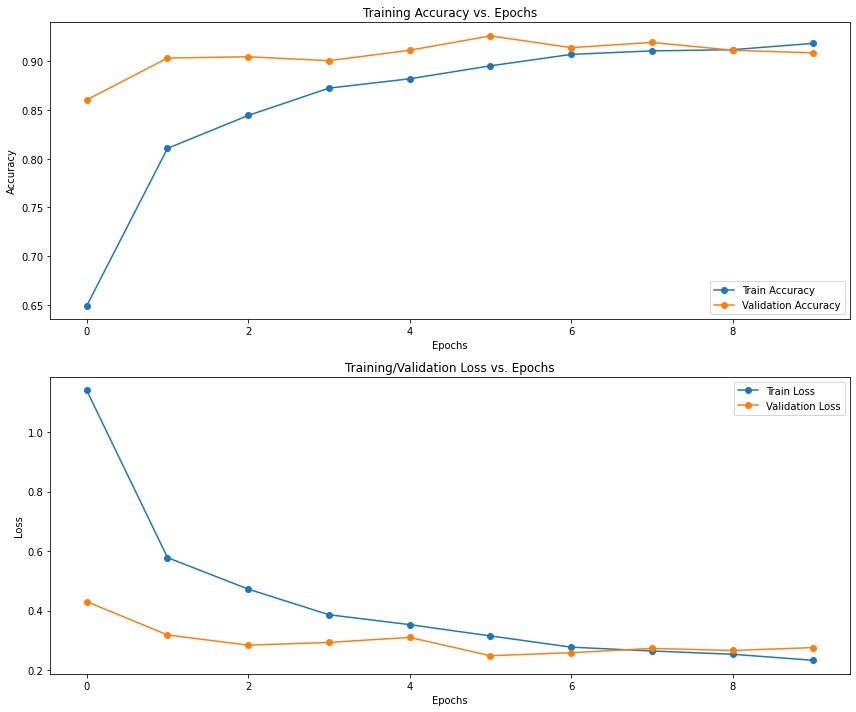

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [22]:
test_dataset = '/content/drive/MyDrive/Monument_Final_Data/test'

In [23]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 251 images belonging to 15 classes.


8/8 [==============================] - 2s 268ms/step


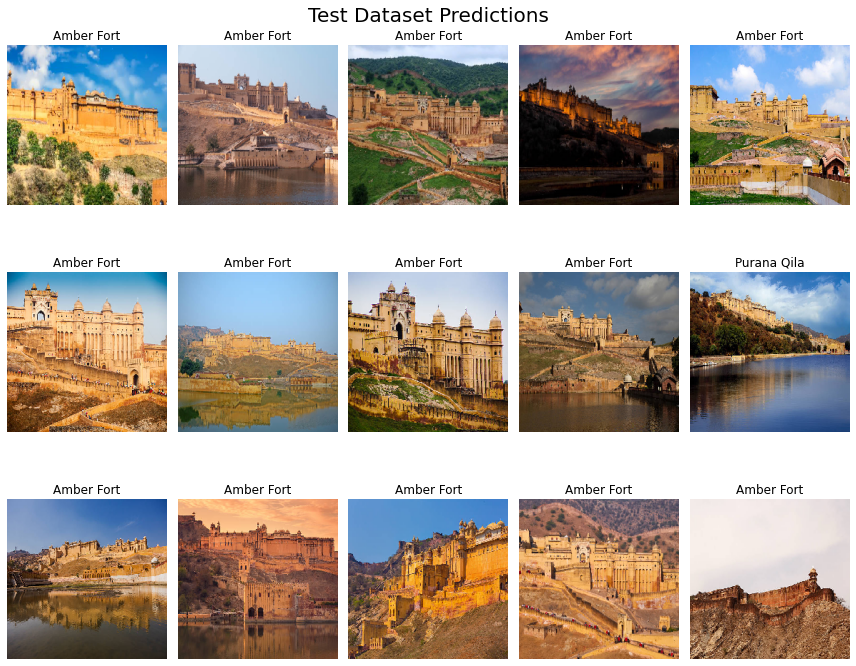

In [25]:
predictions = inception_base.predict(test_generator)
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
idx = 0

for i in range(3):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [26]:
test_loss, test_accuracy = inception_base.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 2s 266ms/step - loss: 0.2682 - accuracy: 0.9124


In [27]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.26818856596946716
Test Accuracy: 0.912350594997406


In [28]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

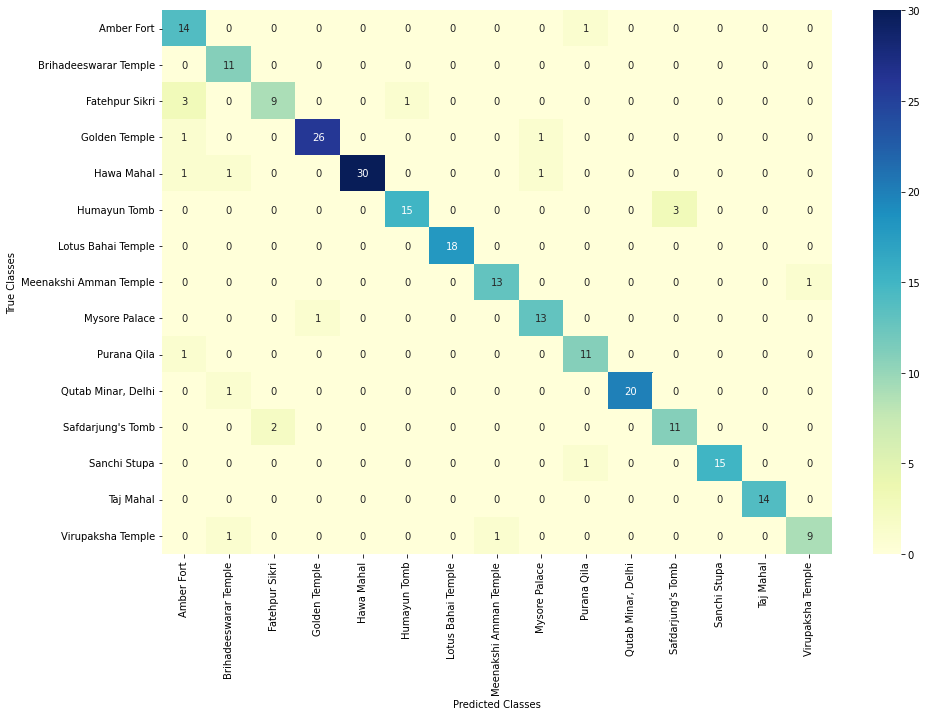

In [29]:
cf_mtx = confusion_matrix(y_true, y_pred)
# print(cf_mtx)
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}" for v1 in group_counts]
box_labels = np.asarray(box_labels).reshape(15, 15)

plt.figure(figsize = (15, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                        precision    recall  f1-score   support

            Amber Fort       0.70      0.93      0.80        15
 Brihadeeswarar Temple       0.79      1.00      0.88        11
        Fatehpur Sikri       0.82      0.69      0.75        13
         Golden Temple       0.96      0.93      0.95        28
            Hawa Mahal       1.00      0.91      0.95        33
          Humayun Tomb       0.94      0.83      0.88        18
    Lotus Bahai Temple       1.00      1.00      1.00        18
Meenakshi Amman Temple       0.93      0.93      0.93        14
         Mysore Palace       0.87      0.93      0.90        14
           Purana Qila       0.85      0.92      0.88        12
    Qutab Minar, Delhi       1.00      0.95      0.98        21
     Safdarjung's Tomb       0.79      0.85      0.81        13
          Sanchi Stupa       1.00      0.94      0.97        16
             Taj Mahal       1.00      1.00      1.00        14
     Virupaksha Temple       0.90      

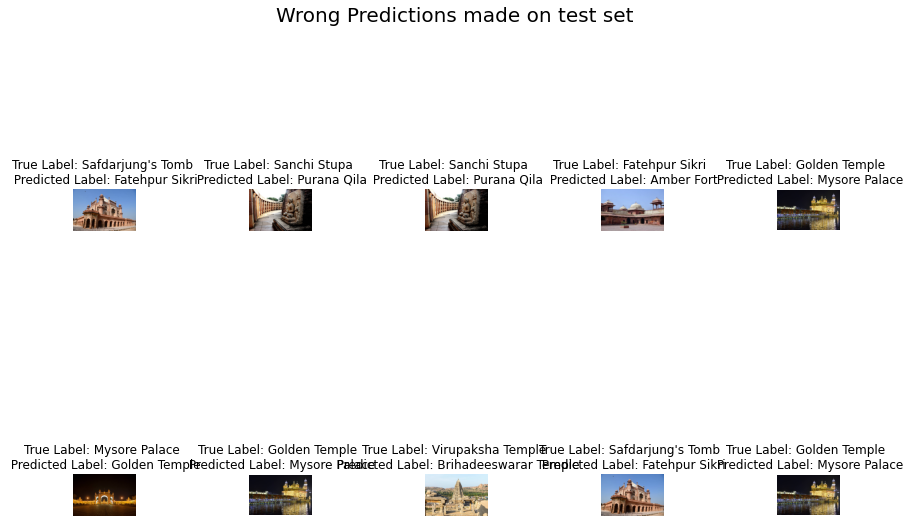

In [31]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [32]:
def predictor(img, model):
    actual_name=img.split('/')[-2]
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print(f'The given image is of \nActual Label: {actual_name} \nPredicted Label: {name}')

1/1 [==============================] - 2s 2s/step
The given image is of 
Actual Label: Safdarjung_s Tomb 
Predicted Label: Fatehpur Sikri


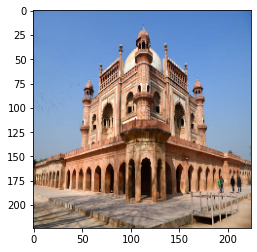

In [34]:
predictor("/content/drive/MyDrive/Monument_Final_Data/test/Safdarjung_s Tomb/gettyimages-906858906-612x612.jpg", inception_base)

1/1 [==============================] - 0s 55ms/step
The given image is of 
Actual Label: Amber Fort 
Predicted Label: Amber Fort


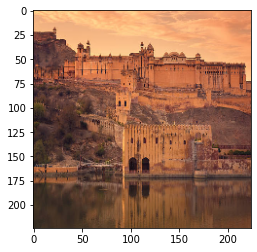

In [35]:
predictor('/content/drive/MyDrive/Monument_Final_Data/test/Amber Fort/gettyimages-636953070-612x612.jpg', inception_base)